Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Train EVI Forecast Model
In this notebook, EVI forecast model is built using satellite and weather (historical and forecast) data on dataset (curated locations spread across USA from Crop Data Layer), which predicts EVI for next 10 days in advance for an Area of Interest (AOI). This notebook runs on the data downloaded from 1_download_data.ipynb notebook. 

### Import Libraries

In [2]:
# Standard library imports
import os
import pickle
import sys
from datetime import datetime

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Disable unnecessary logs 
import logging
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings("ignore")

# Local  imports
from utils.config import farmbeats_config
from utils.constants import CONSTANTS
from utils.ard_util import ard_preprocess
from utils.satellite_util import SatelliteUtil
from utils.weather_util import WeatherUtil

### Get Satellite and Weatther Data

In [3]:
root_dir = CONSTANTS['root_dir']

#### Load satellite data  local paths

In [7]:
sat_links = pd.read_csv(os.path.join(CONSTANTS["results_dir"], "satellite_paths.csv"))
sat_links["fileExist"] = sat_links.filePath.apply(os.path.exists)
sat_links.head()

# TODO: Check fileExist is True for all rows and raise error  

,fileLink,name,resolution,id,sceneDateTime,boundaryId,cloudCoverPercentage,darkPixelPercentage,boundary_count,filePath,fileExist
0,https://internal-wcus.farmbeats.azure.net/scen...,NDVI,10.0,235878a3-498c-58e9-9a91-b72ada3ba579,2021-05-10T00:00:00.000Z,boundary0,0.0,0.0,52,/tmp/farmbeats/Microsoft/Sentinel_2_L2A/contos...,True
1,https://internal-wcus.farmbeats.azure.net/scen...,NDVI,10.0,c6be7105-401f-ecad-b608-73ff2b63835b,2021-05-07T00:00:00.000Z,boundary0,0.0,0.0,52,/tmp/farmbeats/Microsoft/Sentinel_2_L2A/contos...,True
2,https://internal-wcus.farmbeats.azure.net/scen...,NDVI,10.0,b5da188b-8d4a-28d8-0aab-6ee59153bbdc,2021-04-22T00:00:00.000Z,boundary0,0.0,0.0,52,/tmp/farmbeats/Microsoft/Sentinel_2_L2A/contos...,True
3,https://internal-wcus.farmbeats.azure.net/scen...,NDVI,10.0,bcccfcee-9c9c-8a0f-a6da-95270941a3b7,2021-04-17T00:00:00.000Z,boundary0,0.0,0.0,52,/tmp/farmbeats/Microsoft/Sentinel_2_L2A/contos...,True
4,https://internal-wcus.farmbeats.azure.net/scen...,NDVI,10.0,257748c7-839c-faee-9f49-73d6d72442d9,2021-04-10T00:00:00.000Z,boundary0,0.0,0.0,52,/tmp/farmbeats/Microsoft/Sentinel_2_L2A/contos...,True


#### List of weather parameter used in model training

In [8]:
weather_parms = [
    'airTempMax-F', 
    'airTempMin-F', 
    'cloudCover-%', 
    'dewPoint-F', 
    'dewPointMax-F', 
    'dewPointMin-F', 
    'iceAccPeriod-in', 
    'liquidAccPeriod-in', 
    'longWaveRadiationAvg-W/m^2', 
    'petPeriod-in', 
    'precipitation-in', 
    'relativeHumidity-%', 
    'relativeHumidityMax-%', 
    'relativeHumidityMin-%', 
    'shortWaveRadiationAvg-W/m^2', 
    'snowAccPeriod-in', 
    'sunshineDuration-hours', 
    'temperature-F', 
    'windSpeed-mph', 
    'windSpeed2mAvg-mph', 
    'windSpeed2mMax-mph', 
    'windSpeed2mMin-mph', 
    'windSpeedMax-mph', 
    'windSpeedMin-mph'
]

### Prepare Train and Validation sets

In [9]:
# Combine satellite file paths and weather file per boundary

trainval = (
    sat_links.drop_duplicates(["boundaryId", "fileExist"])
    .groupby(["boundaryId"])["fileExist"]
    .agg({"count"})
    .reset_index()
    .query("count == 1")
    .drop(["count"], axis=1)
)


# Check for weather file exists or not
trainval["w_exists"] = (trainval["boundaryId"] + "_historical.csv").apply(lambda x: os.path.join(root_dir, x)).apply(
    os.path.exists
)

trainval = trainval.query("w_exists")

In [10]:
# Split data into train and validation sets in ~70% and ~30% respectively
np.random.seed(10)
trainval["trainval"] = np.where(
    np.random.uniform(0, 1, trainval.shape[0]) < 0.7, "Train", "Val"
)

In [11]:
print(trainval)

  boundaryId  w_exists trainval
0  boundary0      True      Val
1  boundary1      True    Train
2  boundary2      True    Train


In [12]:
# get mean and standard deviation of training data weather parameters for normalization
w_stats = pd.concat(
    [
        pd.read_csv(os.path.join(root_dir, x + "_historical.csv"))
        for x in trainval.query('trainval == "Train"').boundaryId.values
    ],
    axis=0,
)[weather_parms].agg({"mean", "std"})

### Get Weather Statistics for Normalization

In [13]:
# get mean and standard deviation of training data weather parameters for normalization
w_stats = pd.concat(
    [
        pd.read_csv(os.path.join(root_dir, x + "_historical.csv"))
        for x in trainval.query('trainval == "Train"').boundaryId.values
    ],
    axis=0,
)[weather_parms].agg({"mean", "std"})


weather_mean = w_stats.filter(like="mean", axis=0)[weather_parms].values
weather_std = w_stats.filter(like="std", axis=0)[weather_parms].values

# Save weather parameters normalization stats
os.makedirs(os.path.dirname(CONSTANTS["w_pkl"]), exist_ok=True)
with open(CONSTANTS["w_pkl"], "wb+") as f:
    pickle.dump([weather_parms, weather_mean, weather_std], f)

In [14]:
def get_ARD(boundaryId):
    # function for preparing Analysis Ready Dataset
    # intended for use in _2_build_model.py
    
    boundary_id_sat_links = sat_links.query(
        'boundaryId == @boundaryId'
    )
     
    # in reading w_df, if error occurs with farm_code, change it to field_id
    w_df = pd.read_csv(os.path.join(root_dir, boundaryId + "_historical.csv"))
    
    da_pc = ard_preprocess(
        sat_file_links=boundary_id_sat_links,
        w_df=w_df,
        sat_res_x=20,
        var_name=CONSTANTS["var_name"],
        interp_date_start=CONSTANTS["interp_date_start"],
        interp_date_end=CONSTANTS["interp_date_end"],
        w_parms=weather_parms,
        input_days=CONSTANTS["input_days"],
        output_days=CONSTANTS["output_days"],
        ref_tm=CONSTANTS["ref_tm_model"],
        w_mn=weather_mean,
        w_sd=weather_std,
    )
    return da_pc.query(
        "nan_input_evi and nan_input_w and nan_output_evi and nan_output_w and input_evi_le1 and output_evi_le1"
    )

### Create Analysis Ready Dataset (ARD)

In [15]:
# Get analysis ready dataset
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=100) as executor:
    ards_fetch = [executor.submit(get_ARD, x) for x in trainval.boundaryId.values]

In [16]:
ards_fetch[0].result() # sample model input xarray of first boundary

,lat_,long_,grp1_,input_evi,input_weather,forecast_weather,output_evi,input_evi_le1,output_evi_le1,nan_input_evi,nan_input_w,nan_output_evi,nan_output_w
205,46.670928,-97.063391,2.0,"[[0.11104569461863838], [0.10897067325086299],...","[[-2.668340873408142, -2.1543828151177946, 1.0...","[[-1.480488337830546, -1.7354337102173574, -0....","[[0.2221598250230731], [0.22500123573858305], ...",True,True,True,True,True,True
206,46.670928,-97.063391,3.0,"[[0.20990959338435608], [0.2048448848277818], ...","[[-1.3485047227663687, -1.8750834118508364, 0....","[[-3.26226714119694, -2.503507069201492, 0.603...","[[0.05564604437032267], [0.05183542590608403],...",True,True,True,True,True,True
207,46.670928,-97.063391,4.0,"[[0.016742475943900242], [0.01383843629405176]...","[[-2.9982999110685853, -2.2940325167512734, 0....","[[-4.648095099370802, -4.877551996970635, -0.8...","[[0.048956284882815206], [0.049574203440148415...",True,True,True,True,True,True
208,46.670928,-97.063391,5.0,"[[0.08938524433760969], [0.09676993587495475],...","[[-1.678463760426812, -1.4561343069503991, 0.8...","[[-1.5464801453626347, -2.2940325167512734, -0...","[[0.212660275930121], [0.21359955424284693], [...",True,True,True,True,True,True
212,46.670928,-97.061596,2.0,"[[0.1146685063628308], [0.11270818233087534], ...","[[-2.668340873408142, -2.1543828151177946, 1.0...","[[-1.480488337830546, -1.7354337102173574, -0....","[[0.20340598334987015], [0.20583955144937077],...",True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,46.663706,-97.056210,5.0,"[[0.0649898540789068], [0.07430353121691172], ...","[[-1.678463760426812, -1.4561343069503991, 0.8...","[[-1.5464801453626347, -2.2940325167512734, -0...","[[0.15691392622759676], [0.1574505770910212], ...",True,True,True,True,True,True
44,46.663706,-97.054415,2.0,"[[0.11921553633857007], [0.1164741927994773], ...","[[-2.668340873408142, -2.1543828151177946, 1.0...","[[-1.480488337830546, -1.7354337102173574, -0....","[[0.18126091236240693], [0.1812357010372899], ...",True,True,True,True,True,True
45,46.663706,-97.054415,3.0,"[[0.15417775545004372], [0.14920126874351466],...","[[-1.3485047227663687, -1.8750834118508364, 0....","[[-3.26226714119694, -2.503507069201492, 0.603...","[[0.02737906266407869], [0.024467744128448484]...",True,True,True,True,True,True
46,46.663706,-97.054415,4.0,"[[0.0020055757803993314], [0.00042860668594825...","[[-2.9982999110685853, -2.2940325167512734, 0....","[[-4.648095099370802, -4.877551996970635, -0.8...","[[0.017830664707621402], [0.01766247577589224]...",True,True,True,True,True,True


In [17]:
data = pd.concat(
    [
        ards_fetch[x]
        .result()
        .assign(
            boundary_code=trainval.boundaryId.values[x], trainval=trainval.trainval.values[x]
        )
        for x in range(len(trainval.boundaryId.values))
        if ards_fetch[x].exception() == None
    ],
    axis=0,
)

### Model Data Preparation

In [18]:
data_train = data.query('trainval == "Train"')
data_val = data.query('trainval == "Val"')

# Prepare train and validation tensors
# converting list variables in ARD DataFrame to numpy array (tensors)
X_train = [
    np.array(data_train.input_evi.to_list()),
    np.array(data_train.input_weather.to_list()),
    np.array(data_train.forecast_weather.to_list()),
]
Y_train = np.array(data_train.output_evi.to_list())


X_val = [
    np.array(data_val.input_evi.to_list()),
    np.array(data_val.input_weather.to_list()),
    np.array(data_val.forecast_weather.to_list()),
]
Y_val = np.array(data_val.output_evi.to_list())

# Save Analysis Ready Dataset (ARD)
os.makedirs(os.path.dirname(CONSTANTS["ardpkl"]), exist_ok=True)
with open(CONSTANTS["ardpkl"], "wb") as f:
    pickle.dump(data, f)

### Model Architecture

In [19]:
def get_model(input_weather, x, y, z):
    """
    Model architecture
    """
    # intended for use in _2_build_model.py
    # Define the tensors for the three input images
    evi_input = keras.Input((CONSTANTS["input_days"], 1), name="evi_input")
    weather_input = keras.Input(
        (CONSTANTS["input_days"], input_weather), name="weather_input"
    )
    forecast_input = keras.Input(
        (CONSTANTS["output_days"], input_weather), name="forecast_input"
    )

    dense_1 = keras.layers.LSTM(
        x, activation="relu", name="DeNse_1", dropout=0.1, recurrent_dropout=0.1
    )(evi_input)
    dense_2 = keras.layers.LSTM(
        y, activation="relu", name="DeNse_2", dropout=0.1, recurrent_dropout=0.1
    )(weather_input)
    dense_3 = keras.layers.LSTM(
        z,
        activation="relu",
        name="lstm_1",
        return_sequences=True,
        dropout=0.1,
        recurrent_dropout=0.1,
    )(forecast_input)

    dense_12 = keras.layers.concatenate(axis=-1, inputs=[dense_1, dense_2])
    dense_12_1 = keras.layers.RepeatVector(10)(dense_12)
    dense_123 = keras.layers.concatenate(axis=-1, inputs=[dense_12_1, dense_3])
    prediction = keras.layers.LSTM(
        1, activation="relu", name="lstm_2", return_sequences=True
    )(dense_123)
    # Connect the inputs with the outputs
    finnet = keras.Model(
        inputs=[evi_input, weather_input, forecast_input], outputs=prediction
    )
    # return the model
    return finnet

### Model Training

In [20]:
model = get_model(len(weather_parms), 100, 100, 100)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
# Model run
training_history = model.fit(
    X_train,
    Y_train,
    epochs=20,
    verbose=1,
    validation_data=(X_val, Y_val),
    callbacks=[],
    batch_size=1000,
)
val_pred = model.predict(X_val)
# Save model to h5 format
tf.keras.models.save_model(
    model, filepath= CONSTANTS["modelh5"], save_format="h5", overwrite=True
)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0822 - mse: 0.0822 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 2/20
1/1 [==============================] - 0s 351ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 3/20
1/1 [==============================] - 1s 638ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 4/20
1/1 [==============================] - 0s 383ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.1363 - val_mse: 0.1363
Epoch 5/20
1/1 [==============================] - 0s 338ms/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.1605 - val_mse: 0.1605
Epoch 6/20
1/1 [==============================] - 0s 425ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.2815 - val_mse: 0.2815
Epoch 7/20
1/1 [==============================] - 0s 344ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.2783 - val_mse: 0.2783
Epoch 8/20
1/1 [==============================] - 0s 378ms/step - loss: 0.0164 - mse: 0.0164 

### Visualization of Model Results on Validation Dataset

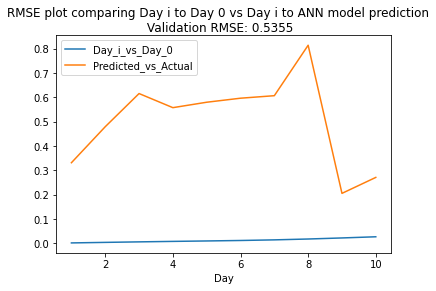

In [21]:
# visualize model error as function of forecast days
err_pred = Y_val[:, :, 0] - val_pred[:, :, 0]
err_base = -Y_val[:, :, 0] + X_val[0][:, -1, 0][:, np.newaxis]
df_err_mn = pd.DataFrame(
    {
        "Day_i_vs_Day_0": np.sqrt(np.mean(err_base ** 2, axis=0)),
        "Predicted_vs_Actual": np.sqrt(np.mean(err_pred ** 2, axis=0)),
        "Day": 1 + np.arange(CONSTANTS["output_days"]),
    }
).set_index(["Day"])
df_err_mn.plot()
plt.suptitle(
    "RMSE plot comparing Day i to Day 0 vs Day i to ANN model prediction\n Validation RMSE: "
    + str(np.round(np.sqrt(training_history.history["val_mse"][-1]), 4))
)
plt.savefig(CONSTANTS["model_result_png"])